In [3]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxa
from scipy import stats
from pyproj import Transformer

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]
netcdf_fps = '/bsuhome/zacharykeskinen/scratch/data/uavsar/images/vv_coherence'

data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv_3.pkl'), 'rb') as f:
    cor_vv = pickle.load(f)

In [7]:
def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

In [8]:
lcfull = rxa.open_rasterio('/bsuhome/zacharykeskinen/scratch/data/uavsar/land-cover/nlcd_2019_land_cover_l48_20210604.img')

In [9]:
transformer = Transformer.from_crs("epsg:4326", lcfull.rio.crs)
for loc, ds in cor_vv.items():
    if 'landcover' not in cor_vv[loc].data_vars:
        left, bottom = transformer.transform(*ds.rio.bounds()[:2][::-1])
        right, top = transformer.transform(*ds.rio.bounds()[2:][::-1])
        clip = lcfull.rio.clip_box(left, bottom, right, top)
        re = clip.rio.reproject_match(cor_vv[loc])[0]
        cor_vv[loc]['landcover'] = re.where(re != 255)

In [10]:
data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv_3.pkl'), 'wb') as f:
    pickle.dump(cor_vv, f)

In [15]:
lcs = []
cors = []
for loc, ds in cor_vv.items():
        lc = ds['landcover'].values.ravel()
        cor = ds['cor_vv'].mean(dim = 'band').values.ravel()
        lc, cor = clean_nps([lc, cor])
        lcs.append(lc)
        cors.append(cor)
lc = np.concatenate(lcs)
cors = np.concatenate(cors)

In [34]:
lcdic = {-1:'All Classifications', 11: 'Water', 41: 'Deciduous Forest', 42: 'Evergreen Forest', 52: 'Shrub', 71:'Grassland',12:'Perrenial Snow'}

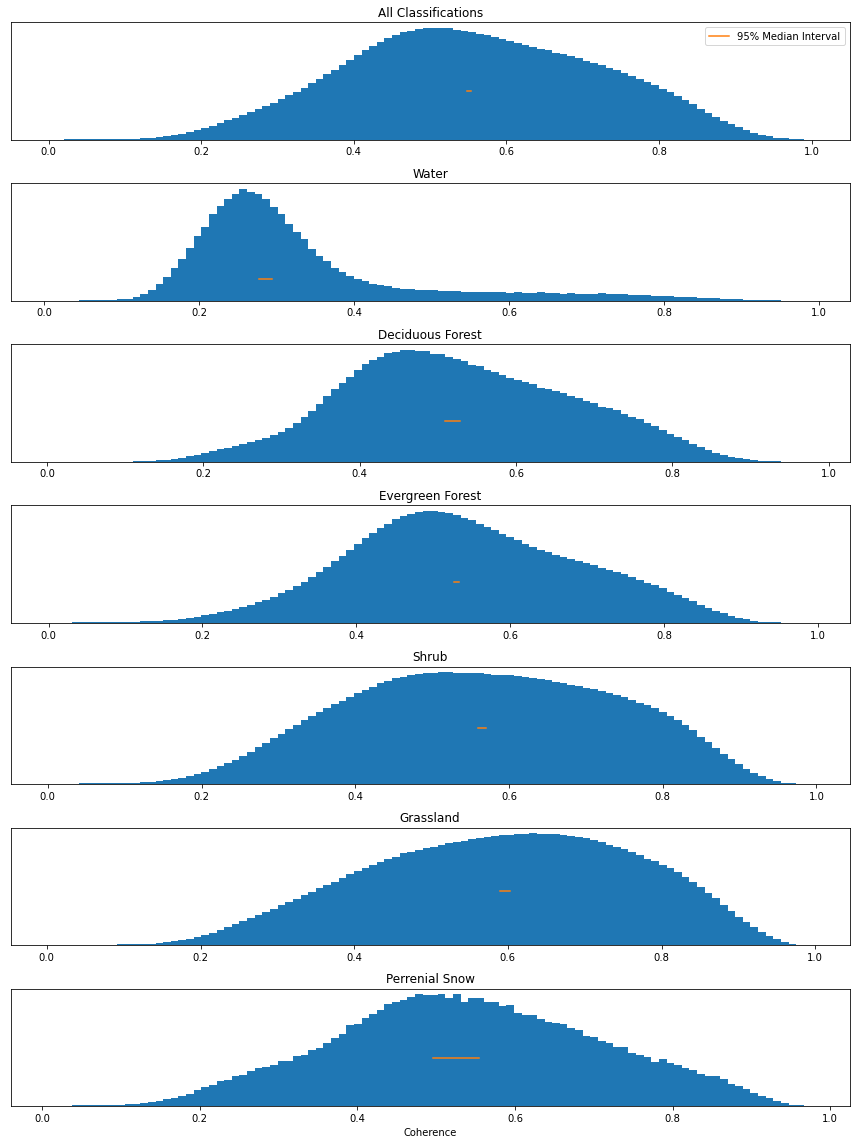

In [77]:
from scipy.stats import bootstrap
f, axes = plt.subplots(7, figsize = (12,16))

for ax_i, (i, label) in enumerate(lcdic.items()):
    ax = axes[ax_i]
    if i == -1:
        x = cors
        ax.hist(cors, bins = 100, density=True)
    else:
        x = cors[lc == i]
        ax.hist(cors[lc == i], label = label, density = True, bins = 100)
    ci_l, ci_h = bootstrap((x[::1000],), np.median).confidence_interval
    if i == -1:
        ax.plot([ci_l, ci_h], [1,1], label = '95% Median Interval')
        ax.legend()
    else:
        ax.plot([ci_l, ci_h], [1,1])
    ax.set_title(label)
    ax.set_yticks([],[])
    if ax_i == len(lcdic)-1:
        ax.set_xlabel('Coherence')
plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/landcover/landcover-cor.png')

In [85]:
lcs = []
cors = []
incs = []
for loc, ds in cor_vv.items():
        for dir in np.unique([d.split('_')[1][:3] for d in ds.band.values]):
                if loc == 'Los_Alamos,_NM':
                        sub = ds
                else:
                        sub = ds.sel({'band':[b for b in ds.band.values if f'_{dir}' in b]})
                cor = sub['cor_vv'].mean(dim = 'band').values.ravel()
                inc = cor_vv[loc][f'{dir}-inc'].values.ravel()
                lc = sub['landcover'].values.ravel()
                lc, cor, inc = clean_nps([lc, cor,inc])
                lcs.append(lc)
                cors.append(cor)
                incs.append(inc)
lc = np.concatenate(lcs)
cors = np.concatenate(cors)
incs = np.concatenate(incs)

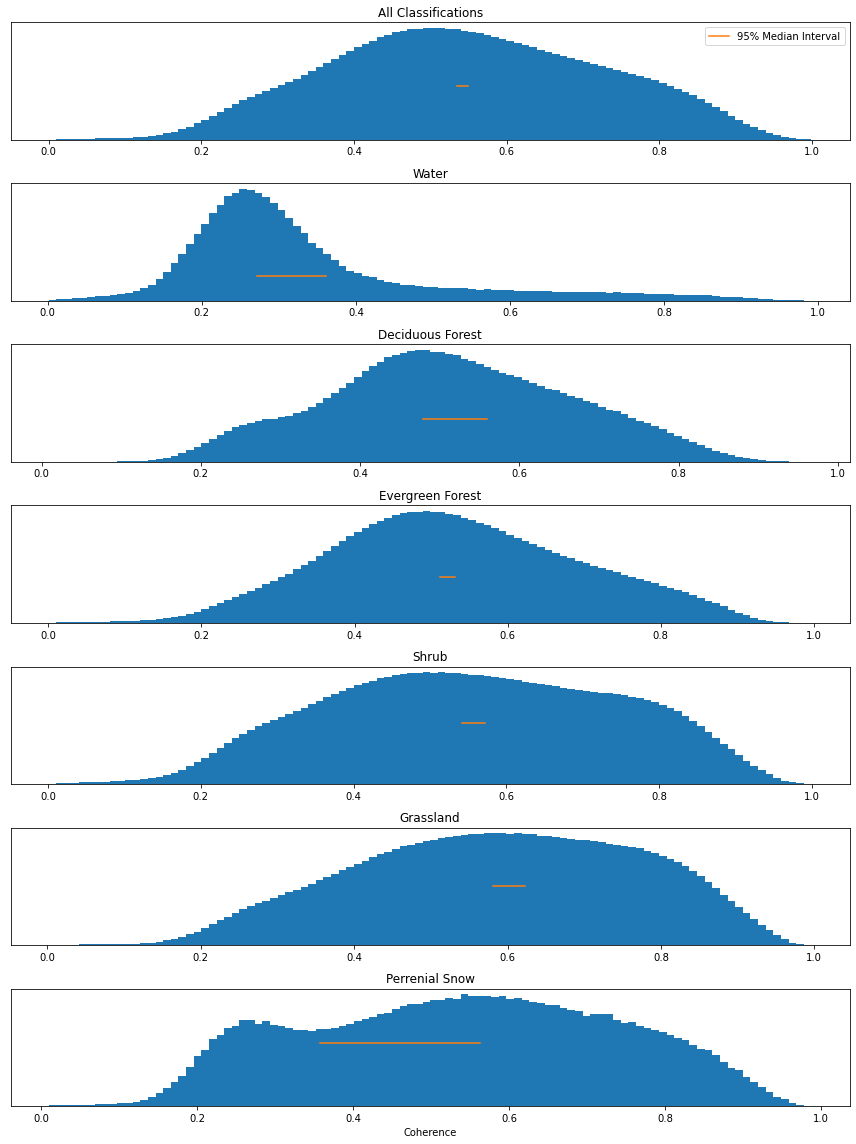

In [89]:
from scipy.stats import bootstrap
f, axes = plt.subplots(7, figsize = (12,16))

for ax_i, (i, label) in enumerate(lcdic.items()):
    ax = axes[ax_i]
    if i == -1:
        x = cors
        ax.hist(cors, bins = 100, density=True)
    else:
        x = cors[lc == i]
        ax.hist(cors[lc == i], label = label, density = True, bins = 100)
    ci_l, ci_h = bootstrap((x[::10000],), np.median).confidence_interval
    if i == -1:
        ax.plot([ci_l, ci_h], [1,1], label = '95% Median Interval')
        ax.legend()
    else:
        ax.plot([ci_l, ci_h], [1,1])
    ax.set_title(label)
    ax.set_yticks([],[])
    if ax_i == len(lcdic)-1:
        ax.set_xlabel('Coherence')
plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/landcover/landcover-inc-cor.png')

# Perennial Snow with Elevation

In [130]:
data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv_3.pkl'), 'rb') as f:
    cor_vv = pickle.load(f)

In [134]:
cor_vv['Los_Alamos,_NM'] = cor_vv['Los_Alamos,_NM'].isel({'band':[0,1]})

In [138]:
ig_dir = '/bsuhome/zacharykeskinen/scratch/data/uavsar/images'
for loc, ds in cor_vv.items():
    images = join(ig_dir, loc.replace('_',' '))
    dem_fp = glob(join(glob(join(images, '*_grd'))[0], '*VV*hgt.grd.tiff'))[0]
    dem = rxa.open_rasterio(dem_fp)
    dem = dem.rio.reproject_match(cor_vv[loc])
    cor_vv[loc]['elev'] = dem.where(dem>0)[0]

In [141]:
# data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
# with open(join(data_fp,'cor_vv_3.pkl'), 'wb') as f:
#     pickle.dump(cor_vv, f)

In [158]:
lcs = []
cors = []
incs = []
elevs = []
for loc, ds in cor_vv.items():
    for dir in np.unique([d.split('_')[1][:3] for d in ds.band.values]):

        sub = ds.sel({'band':[b for b in ds.band.values if f'_{dir}' in b]})
        cor = sub['cor_vv'].mean(dim = 'band').values.ravel()
        inc = sub[f'{dir}-inc'].values.ravel()
        elev = sub['elev'].values.ravel()
        lc = sub['landcover'].values.ravel()
        lc, cor, inc, elev = clean_nps([lc, cor,inc, elev])
        elev = (elev-np.min(elev))/(np.max(elev)-np.min(elev))
        cond = (inc < np.deg2rad(60)) & (inc > np.deg2rad(40))
        lcs.append(lc[cond])
        cors.append(cor[cond])
        elevs.append(elev[cond])
lc = np.concatenate(lcs)
cors = np.concatenate(cors)
elevs = np.concatenate(elevs)

In [163]:
slope, intercept,r,p, _, _ = r2_value(elevs[lc == 71], cors[lc == 71])

slope: 0.06375848212988587. intercept: 0.5984563602360865. r_value 0.08784019442643826. p value: 0.0
